In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf
from math import ceil
import numpy as np
from scipy import linalg
import math
import pylab as pl
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime
import pickle as pkl
import time
import requests
from matplotlib import rc

# Data Preprocessing

In [2]:
data = pd.read_csv("click_data.csv")

In [3]:
data

,timestamp,id,click
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0
...,...,...,...
1607520,1317599692,id-566439,0
1607521,1317599692,id-566825,0
1607522,1317599693,id-563643,0
1607523,1317599694,id-566431,0


In [4]:
# Contents with the highest clicks
id_list = pd.DataFrame(data.groupby('id')['click'].count()).sort_values('click', ascending=False).head(20).index
id_list

Index(['id-564418', 'id-563846', 'id-563643', 'id-565822', 'id-555224',
       'id-559855', 'id-565515', 'id-560290', 'id-565648', 'id-555528',
       'id-563582', 'id-565533', 'id-565479', 'id-566022', 'id-563115',
       'id-560518', 'id-565930', 'id-565589', 'id-566013', 'id-564335'],
      dtype='object', name='id')

In [5]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s') # convert timestamp to datetime
data['click'] = data['click'].astype(int)
data = data[['datetime', 'id', 'click']]
# Set 'datetime' as the index
data.set_index('datetime', inplace=True)
data

,id,click
datetime,,
2011-10-01 23:54:51,id-560620,0
2011-10-01 23:54:51,id-565648,0
2011-10-01 23:54:51,id-563115,0
2011-10-01 23:54:52,id-552077,0
2011-10-01 23:54:52,id-564335,0
...,...,...
2011-10-02 23:54:52,id-566439,0
2011-10-02 23:54:52,id-566825,0
2011-10-02 23:54:53,id-563643,0


# Converting clicks to CTR
## Example: one-arm

In [8]:
# pick the id with most records as an arm
sample = data[data["id"] == 'id-564418'][["click"]]
sample

,click
datetime,
2011-10-01 23:54:56,0
2011-10-01 23:54:58,0
2011-10-01 23:54:59,0
2011-10-01 23:55:01,0
2011-10-01 23:55:03,0
...,...
2011-10-02 23:54:46,0
2011-10-02 23:54:47,0
2011-10-02 23:54:50,0


In [9]:
# convert click data to CTR data (window size = 1h)
sample["CTR"] = sample.click.rolling(window='1h', center=True).mean()
sample

,click,CTR
datetime,,
2011-10-01 23:54:56,0,0.024718
2011-10-01 23:54:58,0,0.024683
2011-10-01 23:54:59,0,0.024665
2011-10-01 23:55:01,0,0.024648
2011-10-01 23:55:03,0,0.024631
...,...,...
2011-10-02 23:54:46,0,0.011241
2011-10-02 23:54:47,0,0.011245
2011-10-02 23:54:50,0,0.011250


<AxesSubplot: xlabel='datetime'>

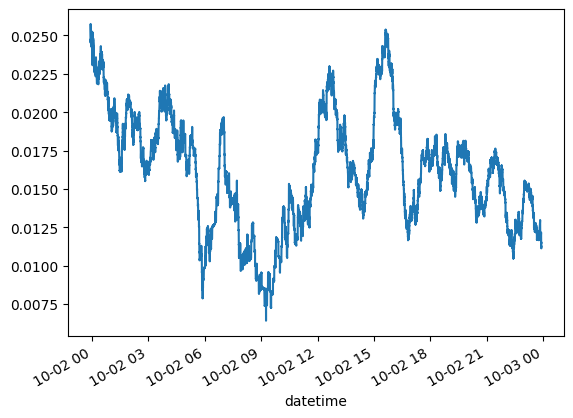

In [10]:
sample.CTR.plot()

In [11]:
# New rows to append
start_row = pd.DataFrame(sample.iloc[[0]])
start_row.index = pd.DatetimeIndex(['2011-10-01 23:54:51'])
end_row = pd.DataFrame(sample.iloc[[-1]])
end_row.index = pd.DatetimeIndex(['2011-10-02 23:54:54'])

# Append a row at the head
resample = pd.concat([start_row, sample])

# # Append a row at the tail
resample = pd.concat([resample, end_row])

resample

,click,CTR
2011-10-01 23:54:51,0,0.024718
2011-10-01 23:54:56,0,0.024718
2011-10-01 23:54:58,0,0.024683
2011-10-01 23:54:59,0,0.024665
2011-10-01 23:55:01,0,0.024648
...,...,...
2011-10-02 23:54:47,0,0.011245
2011-10-02 23:54:50,0,0.011250
2011-10-02 23:54:50,0,0.011250
2011-10-02 23:54:51,0,0.011250


In [12]:
# Resample the DataFrame to ensure there is one row for each second
resample = resample.resample('1s').mean()
resample["ffill"] = resample.CTR.ffill()
resample["bfill"] = resample.CTR.bfill()
resample["CTR"] = (resample["ffill"]+resample["bfill"])/2
resample

,click,CTR,ffill,bfill
2011-10-01 23:54:51,0.0,0.024718,0.024718,0.024718
2011-10-01 23:54:52,NaN,0.024718,0.024718,0.024718
2011-10-01 23:54:53,NaN,0.024718,0.024718,0.024718
2011-10-01 23:54:54,NaN,0.024718,0.024718,0.024718
2011-10-01 23:54:55,NaN,0.024718,0.024718,0.024718
...,...,...,...,...
2011-10-02 23:54:50,0.0,0.011250,0.011250,0.011250
2011-10-02 23:54:51,0.0,0.011250,0.011250,0.011250
2011-10-02 23:54:52,NaN,0.011250,0.011250,0.011250
2011-10-02 23:54:53,NaN,0.011250,0.011250,0.011250


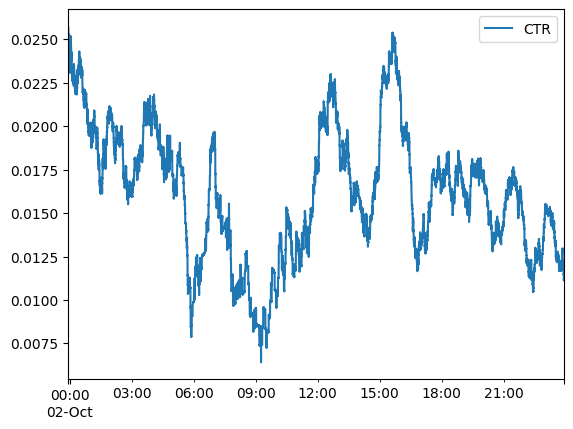

In [13]:
resample.CTR.plot()
plt.legend()

In [14]:
resample.CTR.to_numpy()

array([0.02471751, 0.02471751, 0.02471751, ..., 0.01125   , 0.01125   ,
       0.01125   ])

## Multi-arm

In [15]:
def Click2CTR(data, content_id, start, end):
    
    '''
    Convert click data to CTR data for each content id
    input: 
        - data: click data (dataframe)
        - content_id: content id (string)
        - start: start time of the study period (string in the format of yyyy-mm-dd hh:mm:ss)
        - end: end time of the study period (string in the format of yyyy-mm-dd hh:mm:ss)
    output: 
        - CTR (np.array)
    '''
    
    
    sample = data[data["id"] == content_id].copy()
    sample = sample[["click"]]
    sample["CTR"] = sample.click.rolling(window='1h', center=True).mean()
    
    # New rows to append
    start_row = pd.DataFrame(sample.iloc[[0]])
    start_row.index = pd.DatetimeIndex([start])
    end_row = pd.DataFrame(sample.iloc[[-1]])
    end_row.index = pd.DatetimeIndex([end])
    
    # Append a row at the head and a row at the tail
    resample = pd.concat([start_row, sample])
    resample = pd.concat([resample, end_row])
    
    # Resample the DataFrame to ensure there is one row for each second
    resample = resample.resample('1s').mean()
    resample["ffill"] = resample.CTR.ffill()
    resample["bfill"] = resample.CTR.bfill()
    resample["CTR"] = (resample["ffill"]+resample["bfill"])/2
    
#     # Replace 'click' with values drawn from a Bernoulli distribution using the mean from 'CTR' column
#     resample['click'] = np.random.binomial(1, resample["CTR"])
    
#     # Compute the rolling window mean for the "click" column as CTR
#     resample['CTR'] = resample['click'].rolling(window='1h', center=True).mean()
    
    return resample.CTR

### Converting click data to CTR data

In [16]:
'''
    Convert click data to CTR data for top 20 contents with most records in the study period
'''

start = '2011-10-01 23:54:51'
end = '2011-10-02 23:54:54'
CTR_data = np.empty((0, 86404), dtype=float)
for content_id in id_list:
    CTR = Click2CTR(data=data, content_id=content_id, start=start, end=end)
    CTR_data = np.append(CTR_data, [CTR], axis=0)

In [17]:
CTR_data

array([[0.02471751, 0.02471751, 0.02471751, ..., 0.01125   , 0.01125   ,
        0.01125   ],
       [0.05448029, 0.05448029, 0.05448029, ..., 0.03331909, 0.03331909,
        0.03331909],
       [0.05420431, 0.05420431, 0.05420431, ..., 0.02542726, 0.02543786,
        0.02543786],
       ...,
       [0.04043127, 0.04043127, 0.04040406, ..., 0.03677278, 0.03677278,
        0.03677278],
       [0.03251534, 0.03251534, 0.03251534, ..., 0.02639656, 0.02639656,
        0.02639656],
       [0.01697128, 0.01697128, 0.01697128, ..., 0.01517615, 0.01517615,
        0.01517615]])

### Plotting CTR data

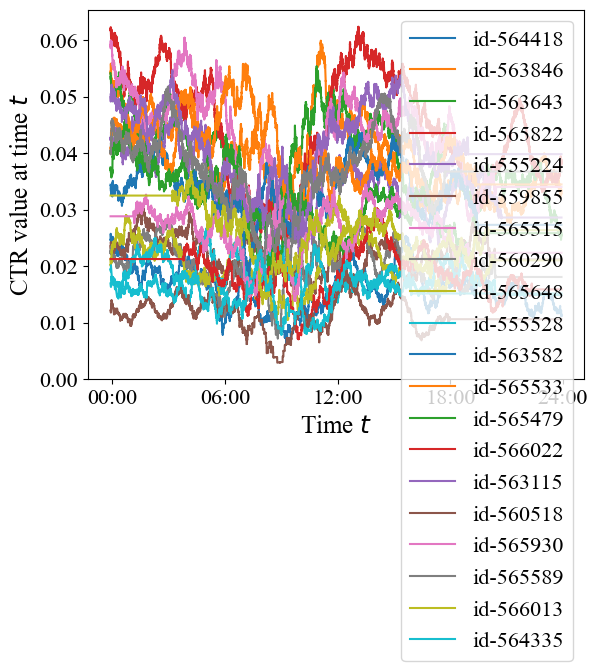

In [18]:
'''
    Plot CTR data of top 20 contents with most records in the study period
'''

rc('font', family='Times New Roman')

# Iterate through each row and plot the corresponding curve
for i in range(20):
    plt.plot(resample.index, CTR_data[i], label=id_list[i])

plt.legend(fontsize=16)
plt.xlabel('Time $t$', fontsize=18)
plt.ylabel('CTR value at time $t$', fontsize=18)

# Create a list of x-axis positions and corresponding labels
x_positions = ["2011-10-02 00:00:00", "2011-10-02 06:00:00", "2011-10-02 12:00:00", "2011-10-02 18:00:00", "2011-10-03 00:00:00"]
x_labels = ["00:00", "06:00", "12:00", "18:00", "24:00"]

# Set the custom tick positions and labels on the x-axis
plt.xticks(x_positions, x_labels, fontsize=16)  # Rotation for better visibility

plt.yticks(fontsize=16)

plt.show()  # Display the plot

### Storing CTR data for later use

In [19]:
'''
    Store CTR data as mean rewards for generating reward tapes and computing regrets)
'''
pkl.dump(CTR_data, open("CTR_data_24h.pkl","wb"))